In [150]:
import os
import pickle
from collections import Counter

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from tqdm import tqdm

from preprocess import (
    remove_punctuation,
    split_sentences,
    process_suffixes,
    get_suffixes,
)

In [19]:
# CONSTANTS
CORPUS_PATH = './corpus'
SUFFIXES = get_suffixes()
WORDS_COUNT_FILE = 'words_count.txt'
PAIR_COOCCURENCES_FILE = 'pair_cooccurences.txt'
MIN_COUNT_THRESHOLD = 2  # All the tokens with counts less than or equal to this will be ignored from consideration
CO_OCCURENCE_WINDOW = 2  # Consider window of two words to consider to have "co-occured"

In [20]:
# GET CORPUS
content_files = os.listdir(CORPUS_PATH)

all_content = []

for filename in content_files:
    path = os.path.join(CORPUS_PATH, filename)
    with open(path, 'r') as f:
        all_content.append(f.read())


In [21]:
def clean_and_extract_sentences(text):
    clean = remove_punctuation(text)
    sentences = split_sentences(clean)
    sentences_word_list = []
    for sentence in sentences:
        splitted = [x for x in sentence.split() if x]
        suffix_processed = process_suffixes(SUFFIXES, splitted)
        sentences_word_list.append(
            [x for x in suffix_processed if x]
        )
    return sentences_word_list

In [22]:
# Get unique words and their corresponding count within corpus
words_count = Counter()
for content in all_content:
    cleaned_sentences = clean_and_extract_sentences(content)
    for sentence in cleaned_sentences:
        words_count.update(sentence)

# Remove low count items
words_count = {k: v for k, v in words_count.items() if v > MIN_COUNT_THRESHOLD}
print(len(words_count))

43355


In [23]:
# Save words list, sorted
import time
s = time.time()
sorted_words_list = sorted(words_count.items(), key=lambda x: x[1], reverse=True)
e = time.time()
print('Time taken to sort : ', e - s)

def write_to_file():
    with open(WORDS_COUNT_FILE, 'w') as f:
        for k, v in sorted_words_list:
            f.write(f'{k} {v}\n')
write_to_file()
print('WRITTEN')

Time taken to sort :  0.01614999771118164
WRITTEN


In [24]:
# LOAD WORD IDS
words_ids = dict()
with open(WORDS_COUNT_FILE, 'r') as f:
    for i, line in enumerate(f.readlines()):
        word, _ = line.split()
        words_ids[word] = i
print('WORD_IDS LOADED')

WORD_IDS LOADED


In [25]:
def get_sentence_cooccurences(sentence_word_ids):
    occurences = Counter()
    for i in range(CO_OCCURENCE_WINDOW):
        shifted = sentence_word_ids[i+1:]
        pairs = zip(sentence_word_ids, shifted)
        sorted_pairs = [tuple(sorted(pair)) for pair in pairs]  # Only work on sorted tuple as (1,2) and (2,1) have same values in the matrix
        occurences.update(Counter(sorted_pairs))
    return occurences

print(get_sentence_cooccurences([1,2,3,4,5,3,1]))

Counter({(3, 4): 2, (3, 5): 2, (1, 3): 2, (1, 2): 1, (2, 3): 1, (4, 5): 1, (2, 4): 1, (1, 5): 1})


In [31]:
pair_cooccurences = Counter()
# Use the sentences list to create coocrurence matrix
for content in all_content:
    cleaned_sentences = clean_and_extract_sentences(content)
    for sentence in cleaned_sentences:
        word_ids = [words_ids[w] for w in sentence if w in words_ids]
        occurences = get_sentence_cooccurences(word_ids)
        pair_cooccurences.update(occurences)
print('DONE creating pair cooccurences')

DONE creating pair cooccurences


In [32]:
# Write pair_cooccurences to a file
print(len(pair_cooccurences))
with open(PAIR_COOCCURENCES_FILE, 'w') as f:
    for (w1_id, w2_id), cooccurences in pair_cooccurences.items():
        f.write(f'{w1_id} {w2_id} {cooccurences}\n')
print(f'Written cooccurences to file {PAIR_COOCCURENCES_FILE}')

2544211
Written cooccurences to file pair_cooccurences.txt


In [75]:
## NOW all the data is processed, we just need to load cooccurences and words_ids files to work with creating vector embeddings

print('LOADING WORD_IDS')
word_ids = {}
word_ids_reverse = {}
with open(WORDS_COUNT_FILE, 'r') as f:
    for i, line in enumerate(f.readlines()):
        if not line.strip():
            continue
        word, _ = line.split()
        word_ids[word] = i
        word_ids_reverse[i] = word
print('LOADED WORD_IDS.')


cooccurrences_symmetric = dict()
print('LOADING COOCCURRENCES...')
with open(PAIR_COOCCURENCES_FILE, 'r') as f:
    for line in f.readlines():
        if not line.strip():
            continue
        w1, w2, occ = line.split()
        pair = tuple(sorted([int(w1), int(w2)]))
        cooccurrences_symmetric[pair] = int(occ)
print('LOADED COOCCURRENCES.')

LOADING WORD_IDS
LOADED WORD_IDS.
LOADING COOCCURRENCES...
LOADED COOCCURRENCES.


In [77]:

def get_standard_deviations(cooccurrences_symmetric, word_ids):
    """
    Get variance of given dimension(here each word contributes as a dimension)
    This will later be used to filter out non varying dimensions
    @parameters:
        - cooccurrences_symmetric: cooccurence matrix
        - word_ids: words(dimensions)
    @returns: a float denoting the variance
    """
    vocab_size = len(word_ids)
    word_cols = {v: [] for v in word_ids.values()}
    word_mean = dict()
    for (w1, w2), occ in tqdm(cooccurrences_symmetric.items()):
        if w1 == w2:
            word_cols[w1].append(occ)
        else:
            word_cols[w1].append(occ)
            word_cols[w2].append(occ)
            
    for k,v in word_cols.items():
        word_mean[k] = sum(v) / vocab_size
    # Now get stds
    stds = dict()
    for k, cols in word_cols.items():
        count = len(cols)
        diff = vocab_size - count  # to account for all the zero values not included in the cols list
        sq_sum = sum([(v - word_mean[k])**2 for v in cols]) + diff * (word_mean[k]**2)
        var = (sq_sum / vocab_size)**0.5
        stds[k] = var
    
    return stds

stds = get_standard_deviations(cooccurrences_symmetric, word_ids)

# sort by min
sorted_stds = sorted(stds.items(), key=lambda x: x[1], reverse=True)


100%|██████████| 2544211/2544211 [00:01<00:00, 2055980.84it/s]


In [90]:
print(len(word_ids), len(word_ids) * 500)
[(word_ids_reverse[w], std) for w, std in sorted_stds[:500]]

43355 21677500


[('N', 314.57061585146124),
 ('जना', 141.90838150508387),
 ('छ', 120.31633821104067),
 ('भए', 116.89596953583634),
 ('र', 101.6471204887892),
 ('हजार', 94.8245688004677),
 ('गरे', 83.18251651923703),
 ('लाई', 81.90002150303681),
 ('कोरोना', 76.7537196709119),
 ('काठमाडौं', 68.97008435760081),
 ('संक्रमण', 67.68804494966761),
 ('लाख', 57.67700680926944),
 ('उन', 57.24165414729157),
 ('पनि', 56.076446846906755),
 ('भने', 55.570557723674945),
 ('सय', 53.89468574189847),
 ('गते', 52.68251183734964),
 ('मृत्यु', 50.38775891757052),
 ('पुष्टि', 49.458200712918284),
 ('छन्', 49.32864497162342),
 ('बाट', 47.70868955195903),
 ('दिए', 45.035118089709634),
 ('पछि', 44.274414161033675),
 ('वर्ष', 43.73484250200516),
 ('करोड', 41.996482855712074),
 ('देखि', 41.35386184500176),
 ('संक्रमित', 40.959078494575785),
 ('जानकारी', 40.58613469179143),
 ('सम्म', 39.86162369334996),
 ('रुपैयाँ', 37.12106556501025),
 ('सरकार', 35.150934103988114),
 ('प्रतिशत', 34.619055737065594),
 ('जनाए', 34.11443203223226)

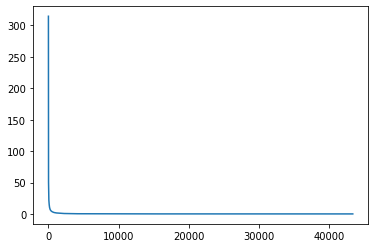

In [96]:
# plot standard deviations
choosen = sorted_stds[:]
std_vals = np.array([v for _, v in choosen])
plt.plot(np.arange(len(choosen)), std_vals)

In [158]:
# Consider only certain number of dimensions with highest standard deviations
N_DIMS_SELECTED = 10000
choosen_dimensions = {k for k, _ in sorted_stds[:N_DIMS_SELECTED]}

# NOW create sparse matrix of all words and their vector representations
all_words_embeds = dict()
for v in tqdm(word_ids.values()):
    vector = []
    for dim in choosen_dimensions:
        pair = tuple(sorted([v, dim]))
        vector.append(cooccurrences_symmetric.get(pair, 0))
    all_words_embeds[v] = vector
print('DONE!!')

100%|██████████| 43355/43355 [05:16<00:00, 137.02it/s]

DONE!!


In [163]:
import json
# write dimensions and word vectors to pkl file
RAW_VECTORS_PATH = 'raw_vectors.pkl'
with open(RAW_VECTORS_PATH, 'wb') as f:
    d = {'dimensions': list(choosen_dimensions)}
    d['word_embeddings'] = sparse.csr_matrix([v for k, v in all_words_embeds.items()])
    pickle.dump(d, f)
print('done writing')

done writing


In [164]:
# READ RAW vectors
with open(RAW_VECTORS_PATH, 'rb') as f:
    vectors_data = pickle.load(f)
print('LOADED VECTORS')
sparse_matrix = vectors_data['word_embeddings']
print('CREATED SPARSE MATRIX')

LOADED VECTORS
CREATED SPARSE MATRIX


(43355, 10000)


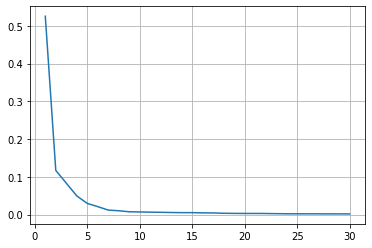

In [168]:
# Perform dimension reduction
print(sparse_matrix.shape)
components = 30
tsvd = TruncatedSVD(n_components=components)
tsvd.fit(sparse_matrix)
plt.plot(np.arange(1, components+1), tsvd.explained_variance_ratio_)
plt.grid(True)

In [169]:
# Write the dimension reduced data to file
transformed = tsvd.transform(sparse_matrix)
print(transformed.shape)
with open('reduced_data_ndarray.pkl', 'wb') as f:
    pickle.dump(transformed, f)
print('Done')

(43355, 30)
Done


In [170]:
# LOAD dim reduced data
with open('reduced_data_ndarray.pkl', 'rb') as f:
    data_array = pickle.load(f)
print('data loaded')

data loaded


In [149]:
# Check for fonts
# Source: https://jdhao.github.io/2018/04/08/matplotlib-unicode-character/

from fontTools.ttLib import TTFont
import matplotlib.font_manager as mfm

def char_in_font(Unicode_char, font):
    for cmap in font['cmap'].tables:
        if cmap.isUnicode():
            if ord(Unicode_char) in cmap.cmap:
                return True
    return False

uni_char =  u"ल"
# or uni_char = u"\u2739"

font_info = [(f.fname, f.name) for f in mfm.fontManager.ttflist]

for i, font in enumerate(font_info):
    try:
        if char_in_font(uni_char, TTFont(font[0], fontNumber=0)):
            print(font[0], font[1])
    except:
        print('no font')


no font
/usr/share/fonts/noto/NotoSansDevanagariUI-Bold.ttf Noto Sans Devanagari UI
/usr/share/fonts/noto/NotoSansDevanagariUI-Light.ttf Noto Sans Devanagari UI
/usr/share/fonts/noto/NotoSerifDevanagari-Black.ttf Noto Serif Devanagari
/usr/share/fonts/noto/NotoSansDevanagariUI-Medium.ttf Noto Sans Devanagari UI
/usr/share/fonts/noto/NotoSerifDevanagari-Bold.ttf Noto Serif Devanagari
no font
/usr/share/fonts/noto/NotoSansDevanagari-Regular.ttf Noto Sans Devanagari
no font
/usr/share/fonts/noto/NotoSansDevanagari-Bold.ttf Noto Sans Devanagari
/usr/share/fonts/noto/NotoSerifDevanagari-Light.ttf Noto Serif Devanagari
/usr/share/fonts/noto/NotoSerifDevanagari-Regular.ttf Noto Serif Devanagari
/usr/share/fonts/noto/NotoSansDevanagariUI-Thin.ttf Noto Sans Devanagari UI
/usr/share/fonts/noto/NotoSansDevanagariUI-Regular.ttf Noto Sans Devanagari UI
/usr/share/fonts/noto/NotoSansDevanagari-Medium.ttf Noto Sans Devanagari
/usr/share/fonts/noto/NotoSansDevanagari-Light.ttf Noto Sans Devanagari
/us

/home/bibek/.local/share/virtualenvs/nepali-vectors-embedding-Od9eAryh/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bibek/.local/share/virtualenvs/nepali-vectors-embedding-Od9eAryh/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


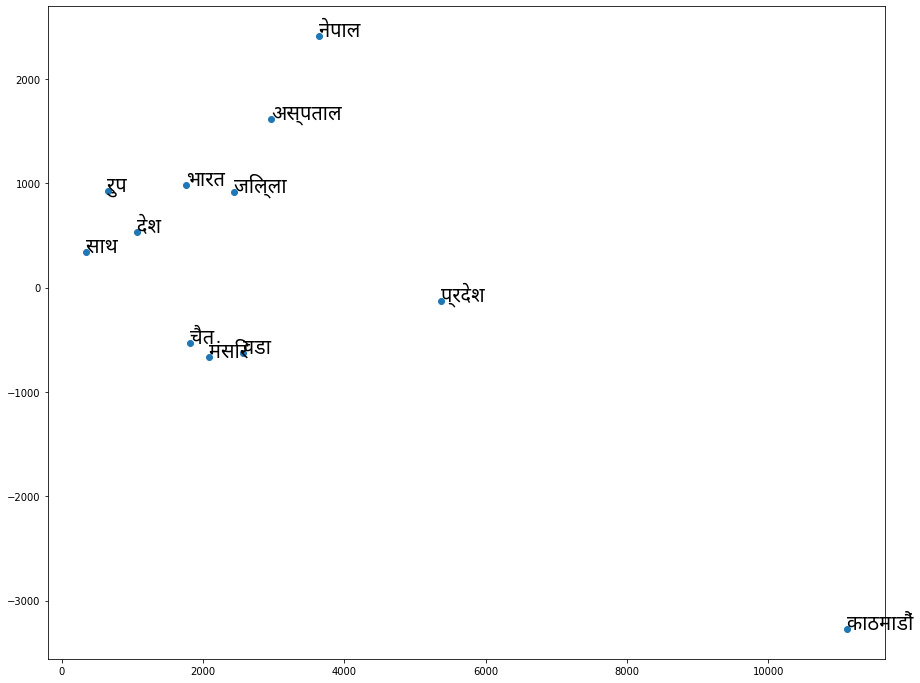

In [187]:
## Add font for plotting
plt.figure(figsize=(15, 12))
prop = fm.FontProperties(fname='/usr/share/fonts/noto/NotoSansDevanagari-Regular.ttf')
# Now reduce to two dimensions and view
svd2 = TruncatedSVD(n_components=2)
data_2d = svd2.fit_transform(data_array)
choosen_indices = [16, 25, 39, 44, 52, 74, 101, 121, 204, 379, 374, 405]
annotations = [word_ids_reverse[x] for x in choosen_indices]
x = data_2d[choosen_indices, 0]
y = data_2d[choosen_indices, 1]
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]), fontproperties=prop, fontsize=20)
plt.scatter(x, y)